## TUGAS T14: EKSPERIMEN SELF-SUPERVISED LEARNING DENGAN SIMCLR
## Nama: Mohammad Ridho Cahyono
## NIM: 442023611050

### Setup dan Import Library

memindahkan semua library menjadi satu diawal

In [1]:
import os
import shutil
import torch
import numpy as np
import yaml
import logging
import csv
import matplotlib.pyplot as plt

from torch import nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
from types import SimpleNamespace
import torch.backends.cudnn as cudnn
import random

print(f"PyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

PyTorch Version: 2.6.0+cu124
Using device: cuda


### Utils

In [2]:
class GaussianBlur(object):
    """blur a single image on CPU"""
    def __init__(self, kernel_size):
        radias = kernel_size // 2
        kernel_size = radias * 2 + 1
        self.blur_h = nn.Conv2d(3, 3, kernel_size=(kernel_size, 1),
                                stride=1, padding=0, bias=False, groups=3)
        self.blur_v = nn.Conv2d(3, 3, kernel_size=(1, kernel_size),
                                stride=1, padding=0, bias=False, groups=3)
        self.k = kernel_size
        self.r = radias
        self.blur = nn.Sequential(nn.ReflectionPad2d(radias), self.blur_h, self.blur_v)
        self.pil_to_tensor = transforms.ToTensor()
        self.tensor_to_pil = transforms.ToPILImage()

    def __call__(self, img):
        img = self.pil_to_tensor(img).unsqueeze(0)
        sigma = np.random.uniform(0.1, 2.0)
        x = np.arange(-self.r, self.r + 1)
        x = np.exp(-np.power(x, 2) / (2 * sigma * sigma))
        x = x / x.sum()
        x = torch.from_numpy(x).view(1, -1).repeat(3, 1)
        self.blur_h.weight.data.copy_(x.view(3, 1, self.k, 1))
        self.blur_v.weight.data.copy_(x.view(3, 1, 1, self.k))
        with torch.no_grad():
            img = self.blur(img)
            img = img.squeeze()
        img = self.tensor_to_pil(img)
        return img

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

### SimCLR

In [3]:
class SimCLR(object):
    def __init__(self, model, optimizer, scheduler, args):
        self.args = args
        self.model = model.to(self.args.device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = torch.nn.CrossEntropyLoss().to(self.args.device)

        os.makedirs(self.args.log_dir, exist_ok=True)
        self.csv_log_path = os.path.join(self.args.log_dir, 'metrics.csv')
        with open(self.csv_log_path, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['epoch', 'step', 'loss', 'acc_top1', 'learning_rate'])

    def info_nce_loss(self, features):
        """
        Memaksimalkan kemiripan antara augmentasi dari gambar yang sama dan pada saat yang sama
        meminimalkan kemiripannya dengan augmentasi dari gambar gambar lain di dalam batch.
        """
        labels = torch.cat([torch.arange(self.args.batch_size) for i in range(self.args.n_views)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(self.args.device)
        features = F.normalize(features, dim=1)
        similarity_matrix = torch.matmul(features, features.T)
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(self.args.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)
        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.args.device)
        logits = logits / self.args.temperature
        return logits, labels

    def train(self, train_loader):
        """
        membuat 2 'view' teraugmentasi dari setiap gambar, melewatkan 'view' melalui model
        untuk mendapatkan output, menghitung nilai loss menggunakan fungsi infoNCE, melakukan
        backpropagation untuk menghitung gradien dan memperbarui bobot model menggunakan optimizer
        """
        scaler = GradScaler(enabled=self.args.fp16_precision)
        n_iter = 0
        print(f"Training {self.args.epochs} epochs...")
        for epoch_counter in range(1, self.args.epochs + 1):
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch_counter}/{self.args.epochs}")
            for images, _ in progress_bar:
                images = torch.cat(images, dim=0)
                images = images.to(self.args.device)
                with autocast(enabled=self.args.fp16_precision):
                    features = self.model(images)
                    logits, labels = self.info_nce_loss(features)
                    loss = self.criterion(logits, labels)
                self.optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.step(self.optimizer)
                scaler.update()
                if n_iter % self.args.log_every_n_steps == 0:
                    top1, _ = accuracy(logits, labels, topk=(1, 5))
                    lr = self.scheduler.get_last_lr()[0]
                    progress_bar.set_postfix({'Loss': loss.item(), 'Top1 Acc': top1[0].item(), 'LR': lr})
                    with open(self.csv_log_path, mode='a', newline='') as f:
                        writer = csv.writer(f)
                        writer.writerow([epoch_counter, n_iter, loss.item(), top1[0].item(), lr])
                n_iter += 1
            if epoch_counter >= 10:
                self.scheduler.step()
        print("Training selesai.")
        checkpoint_name = os.path.join(self.args.log_dir, 'final_checkpoint.pth.tar')
        save_checkpoint({'epoch': self.args.epochs, 'arch': self.args.arch, 'state_dict': self.model.state_dict()}, is_best=False, filename=checkpoint_name)
        print(f"Model disimpan di: {checkpoint_name}")

### Exceptions

In [4]:
class BaseSimCLRException(Exception):
    """Base exception"""


class InvalidBackboneError(BaseSimCLRException):
    """Raised when the choice of backbone Convnet is invalid."""


class InvalidDatasetSelection(BaseSimCLRException):
    """Raised when the choice of dataset is invalid."""


### Dataset dan Augmentasi

In [5]:
class ContrastiveLearningViewGenerator(object):
    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views
    def __call__(self, x):
        return [self.base_transform(x) for i in range(self.n_views)]

class ContrastiveLearningDataset:
    def __init__(self, root_folder):
        self.root_folder = root_folder
    @staticmethod
    def get_simclr_pipeline_transform(size, s=1):
        color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
        data_transforms = transforms.Compose([
            transforms.RandomResizedCrop(size=size), # Agar berfokus dengan bagian gambar yang berbeda
            transforms.RandomHorizontalFlip(), # Agar model dapat mengenali objek dari berbagai sisi
            transforms.RandomApply([color_jitter], p=0.8), # Mengubah properti warna
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Rotasi/ Pergeseran
            transforms.RandomSolarize(128, p=0.2), # Meningkatkan variasi
            GaussianBlur(kernel_size=int(0.1 * size)), # Mengaburkan detail halus
            transforms.ToTensor()
        ])
        return data_transforms
    def get_dataset(self, name, n_views):
        if name == 'tinyimagenet':
            path = os.path.join(self.root_folder, 'train')
            transform = ContrastiveLearningViewGenerator(self.get_simclr_pipeline_transform(64), n_views)
            dataset = datasets.ImageFolder(root=path, transform=transform)
            return dataset
        else:
            raise ValueError("Dataset tidak valid..")

### Model

In [6]:
class ResNetSimCLR(nn.Module):
    def __init__(self, base_model, out_dim):
        super(ResNetSimCLR, self).__init__()

        # Memungkinkan pemilihan antara resnet18, resnet 34 dan 50, pada kali ini saya memakai resnet34
        self.resnet_dict = {
            "resnet18": models.resnet18(weights=None, num_classes=out_dim),
            "resnet34": models.resnet34(weights=None, num_classes=out_dim),
            "resnet50": models.resnet50(weights=None, num_classes=out_dim)
        }
        self.backbone = self._get_basemodel(base_model)
        dim_mlp = self.backbone.fc.in_features

        # Meningkatkan kualitas representasi yang dipelajari backbone
        self.backbone.fc = nn.Sequential(
            nn.Linear(dim_mlp, dim_mlp),
            nn.ReLU(),
            self.backbone.fc
        )
    def _get_basemodel(self, model_name):
        try:
            model = self.resnet_dict[model_name]
            print(f"Backbone '{model_name}'.")
            return model
        except KeyError:
            raise InvalidBackboneError(f"Backbone tidak valid: {model_name}")
    def forward(self, x):
        return self.backbone(x)

### Visualisasi t-SNE

In [7]:
class TinyImageNetTSNEDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_id = {}

        class_names = sorted(os.listdir(root_dir))
        self.class_to_id = {name: i for i, name in enumerate(class_names)}
        self.id_to_class = {i: name for name, i in self.class_to_id.items()}

        for class_name, class_id in self.class_to_id.items():
            class_dir = os.path.join(root_dir, class_name, 'images')
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(class_id)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def visualize_tsne(model, tsne_data_loader, n_samples=1000, device='cuda'):
    print(f"\nMembuat visualisasi t-SNE untuk {n_samples} sampel...")
    model.eval()

    original_fc = model.backbone.fc
    model.backbone.fc = nn.Identity()

    features_list = []
    labels_list = []

    data_iter = iter(tsne_data_loader)
    
    with torch.no_grad():
        for _ in tqdm(range(n_samples // tsne_data_loader.batch_size), desc="Mengekstrak Fitur"):
            try:
                images, labels = next(data_iter)
                images = images.to(device)

                features = model.backbone(images)
                
                features_list.append(features.cpu().numpy())
                labels_list.append(labels.numpy())
            except StopIteration:
                break

    model.backbone.fc = original_fc
    
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    tsne_results = tsne.fit_transform(features)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.6, s=10)
    plt.title('Visualisasi t-SNE')
    plt.xlabel('Komponen t-SNE 1')
    plt.ylabel('Komponen t-SNE 2')

    plt.colorbar(scatter, label='Class ID')
    plt.grid(True)
    plt.show()

### Main

Backbone 'resnet34'.
Training 20 epochs...


/tmp/ipykernel_36/4201125701.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=self.args.fp16_precision)


Epoch 1/20:   0%|          | 0/390 [00:00<?, ?it/s]

/tmp/ipykernel_36/4201125701.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.fp16_precision):


Epoch 2/20:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/390 [00:00<?, ?it/s]

Training selesai.
Model disimpan di: /kaggle/working/logs/simclr/final_checkpoint.pth.tar

Membuat visualisasi t-SNE untuk 2000 sampel...


Mengekstrak Fitur:   0%|          | 0/7 [00:00<?, ?it/s]

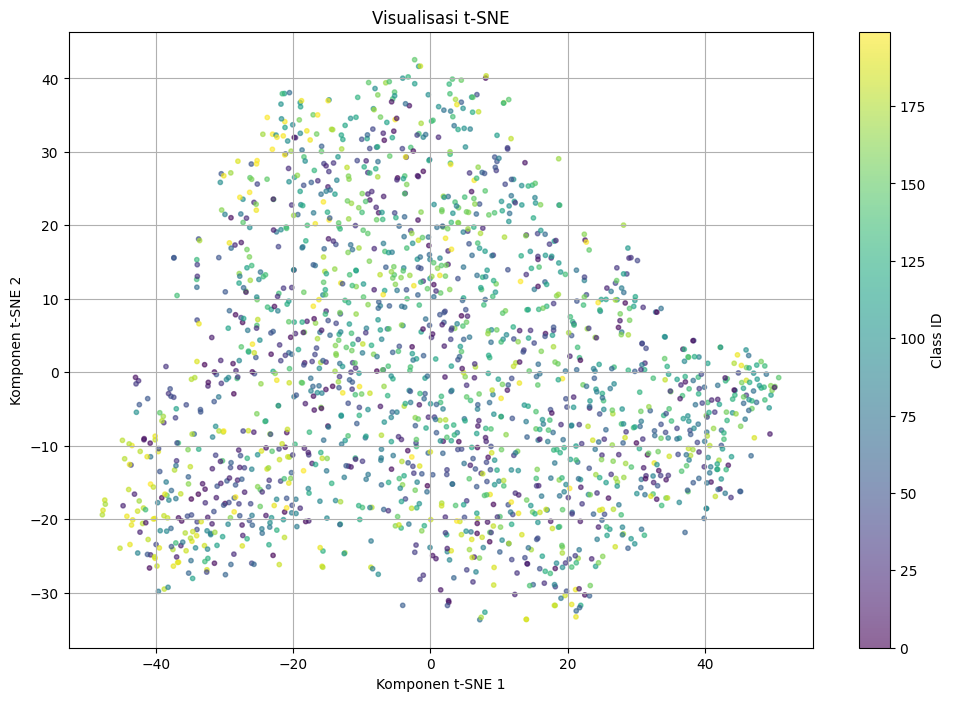

In [8]:
if __name__ == '__main__':
    args = SimpleNamespace()
    args.data = '/kaggle/input/tiny-imagenet/tiny-imagenet-200'
    args.log_dir = '/kaggle/working/logs/simclr'
    args.dataset_name = 'tinyimagenet'
    args.n_views = 2
    args.fp16_precision = torch.cuda.is_available()
    args.workers = 2
    args.epochs = 20
    args.log_every_n_steps = 100

    args.batch_size = 256
    args.lr = 0.0003
    args.weight_decay = 1e-4
    args.temperature = 0.07

    args.arch = 'resnet34'
    args.out_dim = 128
    
    args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cudnn.deterministic = True
    cudnn.benchmark = True

    contrastive_dataset = ContrastiveLearningDataset(args.data)
    train_dataset = contrastive_dataset.get_dataset(args.dataset_name, args.n_views)
    train_loader = DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True, drop_last=True)

    model = ResNetSimCLR(base_model=args.arch, out_dim=args.out_dim)
    optimizer = torch.optim.Adam(model.parameters(), args.lr, weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0)

    simclr_trainer = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, args=args)
    simclr_trainer.train(train_loader)

    tsne_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    tsne_dataset = TinyImageNetTSNEDataset(root_dir=os.path.join(args.data, 'train'), transform=tsne_transform)
    tsne_loader = DataLoader(tsne_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers)
    
    visualize_tsne(model, tsne_loader, n_samples=2000, device=args.device)